<a href="https://colab.research.google.com/github/green-nk/practical-deep-learning/blob/main/lectures/01-getting-started/01-pre-trained-model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<a href="https://colab.research.google.com/github/green-nk/practical-deep-learning/blob/main/is-it-a-bird%3F-pre-trained-model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Introduction

In 2015 the idea of creating a computer system that could recognise birds was considered so outrageously challenging that it was the basis of [this XKCD joke](https://xkcd.com/1425/):

![](https://imgs.xkcd.com/comics/tasks.png)

But today, we can do exactly that, in just a few minutes, using entirely free resources!

The basic steps we'll take are:

1. Use DuckDuckGo to search for images of "bird photos"
2. Use DuckDuckGo to search for images of "forest photos"
3. Fine-tune a pretrained neural network to recognise these two groups
4. Try running this model on a picture of a bird and see if it works.

## Setup

We need to install `fastai` and `duckduckgo-search` as necessary dependencies.

In [1]:
#| echo: false

from google.colab import drive
drive.mount("/content/gdrive")

Mounted at /content/gdrive


In [2]:
!python -m pip install -Uqq fastai duckduckgo-search

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.7/5.7 MB 28.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.0/8.0 MB 52.7 MB/s eta 0:00:00


In [3]:
from duckduckgo_search import DDGS
from fastai.vision.all import *
from fastcore.all import *
from fastdownload import download_url
from time import sleep

## Step 1: Download images of birds and non-birds

Let's start by searching for a bird photo and seeing what kind of result we get. We'll start by getting URLs from a search:

First, we define a helper function called `search_image`. And try searching for a bird photo.

In [4]:
#| code-fold: true

def search_images(term, max_images=30):
    """
    Get image urls from the given term.
    """
    with DDGS() as ddgs:
        ddgs_images_gen = ddgs.images(
            term,
            max_results=max_images
        )

        print(f"Searching for '{term}' ...")
        urls = L(ddgs_images_gen).itemgot("image")

    return urls

In [5]:
urls = search_images('bird photos', max_images=1)
urls[0]

Searching for 'bird photos' ...


'https://images.pexels.com/photos/1661179/pexels-photo-1661179.jpeg?cs=srgb&dl=green-bird-1661179.jpg&fm=jpg'

Note that *DuckDuckGo* get an image urls from text search not image search. That is why we have to include **photos** in the keyword.

...and then download a URL and take a look at it:

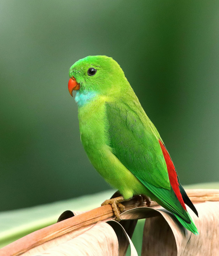

In [6]:
dest = "gdrive/My Drive/practical-deep-learning/bin/bird.jpg"
download_url(urls[0], dest, show_progress=False)

im = Image.open(dest)
sim = im.to_thumb(256, 256)
sim

Also, note that the shape of an image is defined by its height and width respectively.

In [7]:
sim.shape

(256, 219)

Now let's do the same with "forest photos":

Searching for 'forest photos' ...


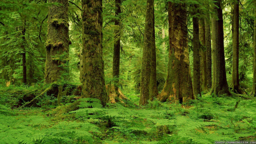

In [8]:
dest = "gdrive/My Drive/practical-deep-learning/bin/forest.jpg"
download_url(search_images('forest photos', max_images=1)[0], dest, show_progress=False)

Image.open(dest).to_thumb(256, 256)

Our searches seem to be giving reasonable results, so let's grab a few examples of each of "bird" and "forest" photos, and save each group of photos to a different folder (I'm also trying to grab a range of lighting conditions here):

In [9]:
searches = "forest", "bird"
conditions = "sun", "shade"
path = Path("gdrive/My Drive/practical-deep-learning/bin/bird-or-not")

for s in searches:
    dest = path/s
    dest.mkdir(exist_ok=True, parents=True)

    # Pause between searches to avoid over-loading server
    download_images(dest, urls=search_images(f"{s} photo"))
    sleep(10)

    for c in conditions:
        download_images(dest, urls=search_images(f"{s} {c} photo"))
        sleep(10)

    resize_images(dest, max_size=400, dest=dest)

Searching for 'forest photo' ...
Searching for 'forest sun photo' ...
Searching for 'forest shade photo' ...
Searching for 'bird photo' ...
Searching for 'bird sun photo' ...
Searching for 'bird shade photo' ...


Note that `resize_images` operates recursively by overwriting files in `dest`. Also, it is reducing the file size to the limited `max_size` so that we can keep data in a local drive.

## Step 2: Train our model

Some photos might not download correctly which could cause our model training to fail, so we'll remove them permanetly from disk:

In [10]:
failed = verify_images(get_image_files(path))
failed.map(Path.unlink)

print(f"Removed {len(failed)} invalid images!")

Removed 6 invalid images!


To train a model, we'll need `DataLoaders`, which is an object that contains a *training set* (the images used to create a model) and a *validation set* (the images used to check the accuracy of a model -- not used during training). In `fastai` we can create that easily using a `DataBlock`, and view sample images from it:

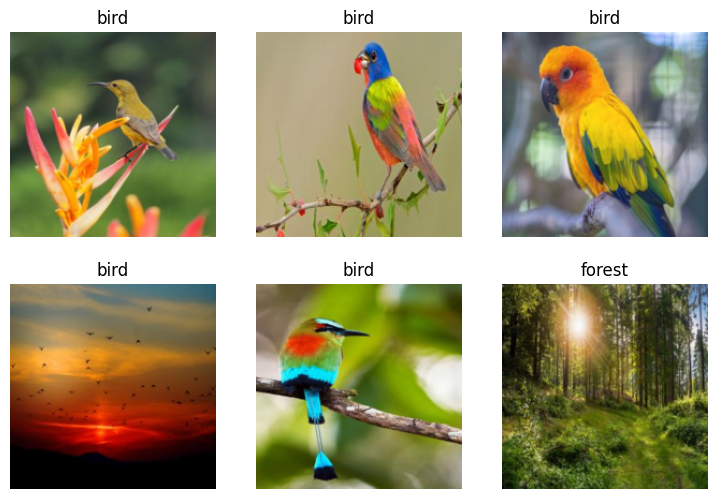

In [11]:
dls = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=[Resize(192, method='squish')]
).dataloaders(path, bs=32)

dls.show_batch(max_n=6)

Here what each of the `DataBlock` parameters means:

```python
blocks=(ImageBlock, CategoryBlock),
```

The inputs to our model are images, and the outputs are categories (in this case, "bird" or "forest").

```python
get_items=get_image_files,
```

To find all the inputs to our model, run the `get_image_files` function (which returns a list of all image files in a path).

```python
splitter=RandomSplitter(valid_pct=0.2, seed=42),
```

Split the data into training and validation sets randomly, using 20% of the data for the validation set.

```python
get_y=parent_label,
```

The labels (`y` values) is the name of the `parent` of each file (i.e. the name of the folder they're in, which will be *bird* or *forest*).

```python
item_tfms=[Resize(192, method='squish')]
```

Before training, resize each image to 192x192 pixels by "squishing" it (as opposed to cropping it).

Now we're ready to train our model. The fastest widely used computer vision model is `resnet18`. You can train this in a few minutes, even on a CPU! (On a GPU, it generally takes under 10 seconds...)

`fastai` comes with a helpful `fine_tune()` method which automatically uses best practices for fine tuning a pre-trained model, so we'll use that.

In [12]:
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(3)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 123MB/s]


epoch,train_loss,valid_loss,error_rate,time
0,0.881389,0.016011,0.000000,00:37


epoch,train_loss,valid_loss,error_rate,time
0,0.110143,0.000960,0.000000,00:58
1,0.060484,0.000762,0.000000,00:55
2,0.041855,0.001080,0.000000,00:51


Generally when I run this I see 100% accuracy on the validation set (although it might vary a bit from run to run).

"Fine-tuning" a model means that we're starting with a model someone else has trained using some other dataset (called the *pretrained model*), and adjusting the weights a little bit so that the model learns to recognise your particular dataset. In this case, the pretrained model was trained to recognise photos in *imagenet*, and widely-used computer vision dataset with images covering 1000 categories).

For details on fine-tuning and why it's important, check out the [lesson-01-intro](01-intro.ipynb/) in the **How our image recognizer works** section.

## Step 3: Use our model (and build your own!)

Let's see what our model thinks about that bird we downloaded at the start:

In [13]:
is_bird, _, probs = learn.predict(PILImage.create("gdrive/My Drive/practical-deep-learning/bin/bird.jpg"))

print(f"This is a: {is_bird}.")
print(f"Probability it's a bird: {probs[0]:.4f}")

This is a: bird.
Probability it's a bird: 0.9999


Good job, resnet18. :)

So, as you see, in the space of a few years, creating computer vision classification models has gone from "so hard it's a joke" to "trivially easy and free"!

It's not just in computer vision. Thanks to deep learning, computers can now do many things which seemed impossible just a few years ago, including [creating amazing artworks](https://openai.com/dall-e-2/), and [explaining jokes](https://www.datanami.com/2022/04/22/googles-massive-new-language-model-can-explain-jokes/). It's moving so fast that even experts in the field have trouble predicting how it's going to impact society in the coming years.

One thing is clear -- it's important that we all do our best to understand this technology, because otherwise we'll get left behind!

**Reference: ** [Is it a bird? Creating a model from your own data](https://www.kaggle.com/code/jhoward/is-it-a-bird-creating-a-model-from-your-own-data)